# <center>Speech Classification Using Neural Networks</center>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import librosa.display
import random as rn
from keras.layers import Dense
from keras import Input
from keras.engine import Model
from keras.utils import to_categorical
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D

Using TensorFlow backend.


### The dataset in the below directory contains 3 speakers and 1,500 recordings (50 of each digit per speaker)

The load method returns the actual sound wave and the ‘sampling rate’.

In [10]:
DIR='recordings/'

In [11]:
random_wav_file = rn.choice(os.listdir(DIR))

In [13]:
wav, sr = librosa.load(DIR + random_wav_file)
print("sr:", sr)
print("wav shape:", wav.shape)
print("Audio length:", wav.shape[0]/float(sr), 'secs')

sr: 22050
wav shape: (10714,)
Audio length: 0.4858956916099773 secs


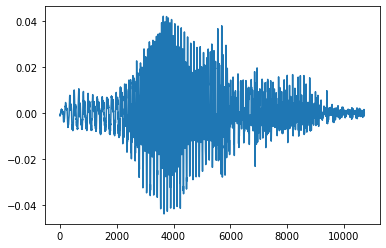

In [14]:
# As seen in the below plot, it is a very complex signal. It is very difficult to find patterns in it
plt.plot(wav)

### Short-time Fourier transform
We can get frequencies from any sound signals. But human speech is not a static noise, it changes over time. To correctly represent human speech, we can break the recordings into small windows and compute what frequencies are used in each window. We can use the Short-time Fourier transform for this. We are using librosa library to accomplish this. 

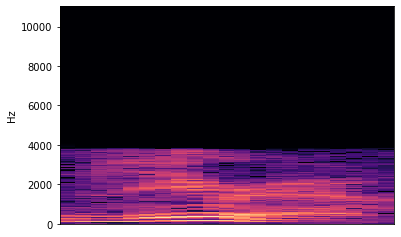

In [15]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max)
librosa.display.specshow(D, y_axis='linear')

### Preparing our datasets
Here we are splitting the data into train and test data

<bold>Note: </bold>
A typical spectrogram uses a linear frequency scaling, so each frequency bin is spaced the equal number of Hertz apart. The mel-frequency scale on the other hand, is a quasi-logarithmic spacing roughly resembling the resolution of the human auditory system. This makes the MFCC features more “biologically inspired”. 

In [18]:
test_speaker = 'theo'
train_X = []
train_spectrograms = []
train_mel_spectrograms = []
train_mfccs = []
train_y = []

test_X =[]
test_spectrograms = []
test_mel_spectrograms = []
test_mfccs = []
test_y = []

pad1d = lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))
pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i - a.shape[1]))))

for fname in os.listdir(DIR):
    try:
        if '.wav' not in fname or 'dima' in fname:
            continue
        struct = fname.split('_')
        digit = struct[0]
        speaker = struct[1]
        wav, sr = librosa.load(DIR + fname)
        padded_x = pad1d(wav, 30000)
        # STFT values are complex numbers. We need use only the real part of it to find the frequency coefficients.
        spectrogram = np.abs(librosa.stft(wav))
        padded_spectogram = pad2d(spectrogram,40)

        mel_spectrogram = librosa.feature.melspectrogram(wav)
        padded_mel_spectrogram = pad2d(mel_spectrogram,40)

        mfcc = librosa.feature.mfcc(wav)
        padded_mfcc = pad2d(mfcc,40)

        if speaker == test_speaker:
            test_X.append(padded_x)
            test_spectrograms.append(padded_spectogram)
            test_mel_spectrograms.append(padded_mel_spectrogram)
            test_mfccs.append(padded_mfcc)
            test_y.append(digit)
        else:
            train_X.append(padded_x)
            train_spectrograms.append(padded_spectogram)
            train_mel_spectrograms.append(padded_mel_spectrogram)
            train_mfccs.append(padded_mfcc)
            train_y.append(digit)
    except Exception as e:
        print(fname, e)
        raise

train_X = np.vstack(train_X)
train_spectrograms = np.array(train_spectrograms)
train_mel_spectrograms = np.array(train_mel_spectrograms)
train_mfccs = np.array(train_mfccs)
train_y = to_categorical(np.array(train_y))

test_X = np.vstack(test_X)
test_spectrograms = np.array(test_spectrograms)
test_mel_spectrograms = np.array(test_mel_spectrograms)
test_mfccs = np.array(test_mfccs)
test_y = to_categorical(np.array(test_y))


print('train_X:', train_X.shape)
print('train_spectrograms:', train_spectrograms.shape)
print('train_mel_spectrograms:', train_mel_spectrograms.shape)
print('train_mfccs:', train_mfccs.shape)
print('train_y:', train_y.shape)
print()
print('test_X:', test_X.shape)
print('test_spectrograms:', test_spectrograms.shape)
print('test_mel_spectrograms:', test_mel_spectrograms.shape)
print('test_mfccs:', test_mfccs.shape)
print('test_y:', test_y.shape)

train_X: (1500, 30000)
train_spectrograms: (1500, 1025, 40)
train_mel_spectrograms: (1500, 128, 40)
train_mfccs: (1500, 20, 40)
train_y: (1500, 10)

test_X: (500, 30000)
test_spectrograms: (500, 1025, 40)
test_mel_spectrograms: (500, 128, 40)
test_mfccs: (500, 20, 40)
test_y: (500, 10)


### MLP network
To start with a simple MLP network with a single hidden layer is used

In [19]:
ip = Input(shape=(train_X[0].shape))
hidden = Dense(128, activation='relu')(ip)
op = Dense(10, activation='softmax')(hidden)
model = Model(input=ip, output=op)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3840128   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 3,841,418
Trainable params: 3,841,418
Non-trainable params: 0
_________________________________________________________________


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


In [20]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

history = model.fit(train_X, 
                    train_y,
                    epochs=10,
                    batch_size=32,
                    validation_data=(test_X, test_y))


Train on 1500 samples, validate on 500 samples
Epoch 1/10
1500/1500 [==============================] - 4s 2ms/step - loss: 2.3004 - acc: 0.1740 - val_loss: 2.2988 - val_acc: 0.1560
Epoch 2/10
1500/1500 [==============================] - 3s 2ms/step - loss: 1.7355 - acc: 0.5120 - val_loss: 2.3006 - val_acc: 0.1540
Epoch 3/10
1500/1500 [==============================] - 3s 2ms/step - loss: 1.3984 - acc: 0.6420 - val_loss: 2.3068 - val_acc: 0.1540
Epoch 4/10
1500/1500 [==============================] - 3s 2ms/step - loss: 1.1478 - acc: 0.7273 - val_loss: 2.3200 - val_acc: 0.1580
Epoch 5/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.9717 - acc: 0.7733 - val_loss: 2.3316 - val_acc: 0.1580
Epoch 6/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.8492 - acc: 0.8093 - val_loss: 2.3501 - val_acc: 0.1400
Epoch 7/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.7527 - acc: 0.8440 - val_loss: 2.3655 - val_acc: 0.1460
Epoch 8/10
1500

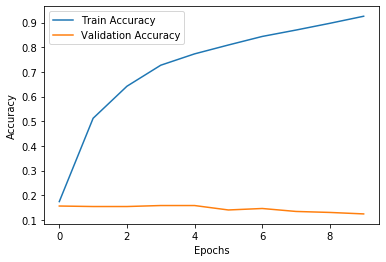

In [21]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### Results of above Plot

As we can see, accuracy on the training data is ok, but it is terrible on the test data. Let's try different network architectures to solve this issue. Since the raw waves are almost never used we’ll move on to the more standard way to represent sound files using 'Spectrograms'

### SPECTROGRAMS CNN
we are able to compute spectrograms for each file in our dataset and use them to classify digits. Spectrograms are like 2D images so we can use image classification techniques on them, specifically Convolutional Neural Networks!

In [22]:
train_X_sp = np.expand_dims(train_spectrograms, -1)
test_X_sp = np.expand_dims(test_spectrograms, -1)
print('train X shape:', train_X_sp.shape)
print('test X shape:', test_X_sp.shape)

train X shape: (1500, 1025, 40, 1)
test X shape: (500, 1025, 40, 1)


In [23]:
ip = Input(shape=train_X_sp[0].shape)
m = Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same')(ip)
m = MaxPooling2D(pool_size=(4, 4))(m)
m = Dropout(0.2)(m)
m = Conv2D(64, kernel_size=(4, 4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4, 4))(m)
m = Dropout(0.2)(m)
m = Flatten()(m)
m = Dense(32, activation='relu')(m)
op = Dense(10, activation='softmax')(m)

model = Model(input=ip, output=op)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1025, 40, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1022, 37, 64)      1088      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 255, 9, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 255, 9, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 146880)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4700192   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total para

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':


In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X_sp,
          train_y,
          epochs=10,
          batch_size=32,
          verbose=1,
          validation_data=(test_X_sp, test_y))

Train on 1500 samples, validate on 500 samples
Epoch 1/10
1500/1500 [==============================] - 76s 51ms/step - loss: 1.5182 - acc: 0.5520 - val_loss: 1.8676 - val_acc: 0.4500
Epoch 2/10
1500/1500 [==============================] - 74s 49ms/step - loss: 0.5689 - acc: 0.8447 - val_loss: 1.7497 - val_acc: 0.3780
Epoch 3/10
1500/1500 [==============================] - 75s 50ms/step - loss: 0.3181 - acc: 0.9213 - val_loss: 1.7520 - val_acc: 0.4160
Epoch 4/10
1500/1500 [==============================] - 78s 52ms/step - loss: 0.1592 - acc: 0.9627 - val_loss: 1.7984 - val_acc: 0.4640
Epoch 5/10
1500/1500 [==============================] - 74s 50ms/step - loss: 0.1456 - acc: 0.9580 - val_loss: 1.8420 - val_acc: 0.4800
Epoch 6/10
1500/1500 [==============================] - 81s 54ms/step - loss: 0.1235 - acc: 0.9700 - val_loss: 1.7347 - val_acc: 0.4860
Epoch 7/10
1500/1500 [==============================] - 85s 56ms/step - loss: 0.0510 - acc: 0.9920 - val_loss: 1.9560 - val_acc: 0.4160
E

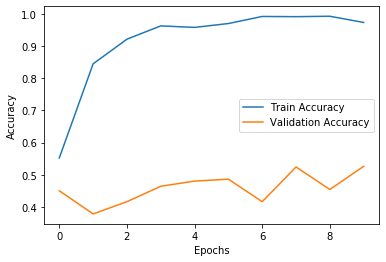

In [25]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### Results of above plot 
Results are better than before, almost close to 60% accurate on the test set. It’s far from perfect, but much better than using the raw waves.

## MEL SPECTROGRAM CNN

In [26]:
train_X_mel = np.expand_dims(train_mel_spectrograms, -1)
test_X_mel = np.expand_dims(test_mel_spectrograms, -1)

print('train X shape:', train_X_mel.shape)
print('test X shape:', test_X_mel.shape)

train X shape: (1500, 128, 40, 1)
test X shape: (500, 128, 40, 1)


In [27]:
ip = Input(shape=train_X_mel[0].shape)
m = Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same')(ip)
m = MaxPooling2D(pool_size=(4, 4))(m)
m = Dropout(0.2)(m)
m = Conv2D(64, kernel_size=(4, 4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4, 4))(m)
m = Dropout(0.2)(m)
m = Flatten()(m)
m = Dense(32, activation='relu')(m)
op = Dense(10, activation='softmax')(m)

model = Model(input=ip, output=op)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 40, 1)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 37, 64)       1088      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 9, 64)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 31, 9, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 17856)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                571424    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
Total para

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':


In [28]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X_mel,
                    train_y,
                    epochs=10,
                    batch_size=32,
                    verbose=0,
                    validation_data=(test_X_mel, test_y))

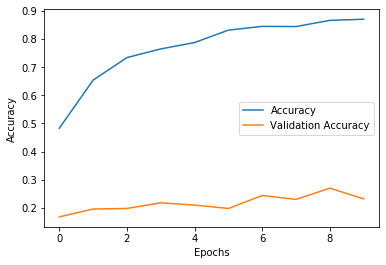

In [29]:
plt.plot(history.history['acc'], label='Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### Conclusion
We have done the implementation of voice classification using librosa library and Fourier Transformation Algorithm. Representing sounds for machine learning is not so difficult. There are many methods and a lot of research has been done. Fourier Transform is the basic and most widely used algorithm for signal processing, it is the fundamentals of working with sounds.
We have also implemented Spectrograms, Mel-Spectrograms and Mel-frequency cepstral coefficients (MFCCs) to represent sound files.

### References
https://towardsdatascience.com/speech-classification-using-neural-networks-the-basics-e5b08d6928b7